Tahap 4: Customer Segmentation using K-Means Clustering
1. Research Objectives
Mengidentifikasi kelompok nasabah berdasarkan profil risiko dan perilaku keuangan.

Menentukan jumlah klaster optimal menggunakan metode statistik (Elbow Method & Silhouette Score).

Membangun Customer Persona untuk rekomendasi strategi bisnis yang dipersonalisasi.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load data hasil feature engineering (Tahap 3)
df_ml = pd.read_csv("../data/processed/personal_finance_final_ml.csv")
# Load data asli (untuk interpretasi profil nantinya)
df_original = pd.read_csv("../data/processed/personal_finance_cleaned.csv")

# Memilih fitur kunci untuk clustering (fitur yang paling mencerminkan perilaku)
# Kita gunakan fitur yang sudah di-scaling
features_for_clustering = [
    'monthly_income_usd', 'debt_to_income_ratio', 
    'savings_to_income_ratio', 'credit_score', 'disposable_income'
]
X = df_ml[features_for_clustering]

In [4]:
wcss = [] # Within-Cluster Sum of Square
silhouette_avg = []

range_n_clusters = range(2, 9)

from sklearn.utils import resample

wcss = [] 
silhouette_avg = []
range_n_clusters = range(2, 9)

# Gunakan sample data (misal 5000 data) hanya untuk menghitung Silhouette agar cepat
X_sample = resample(X, n_samples=5000, random_state=42) if len(X) > 5000 else X

for n in range_n_clusters:
    # Model K-Means tetap dilatih pada seluruh data (X)
    kmeans = KMeans(n_clusters=n, init='k-means++', random_state=42, n_init=5) # n_init dikurangi ke 5
    cluster_labels = kmeans.fit_predict(X)
    
    # Simpan WCSS dari seluruh data
    wcss.append(kmeans.inertia_)
    
    # Hitung Silhouette Score menggunakan data sample (X_sample) agar hemat waktu
    # Kita perlu prediksi label untuk data sample tersebut
    sample_labels = kmeans.predict(X_sample)
    silhouette_avg.append(silhouette_score(X_sample, sample_labels))

print("Proses seleksi klaster optimal selesai!")

Proses seleksi klaster optimal selesai!


In [8]:
k_optimal = 4 # Contoh nilai k optimal
kmeans_final = KMeans(n_clusters=k_optimal, init='k-means++', random_state=42, n_init=10)
df_original['cluster'] = kmeans_final.fit_predict(X)

print(f"Model K-Means berhasil dilatih dengan {k_optimal} klaster.")

Model K-Means berhasil dilatih dengan 4 klaster.


In [11]:
# 1. Pastikan kolom 'cluster' benar-benar ada
if 'cluster' in df_original.columns:
    
    # 2. Membersihkan spasi di nama kolom agar tidak terjadi KeyError
    df_original.columns = df_original.columns.str.strip()

    # 3. Daftar fitur yang kita inginkan (disesuaikan dengan dataset)
    # Kita gunakan daftar yang fleksibel agar tetap jalan meskipun satu kolom tidak ada
    potential_cols = [
        'monthly_income_usd', 
        'debt_to_income_ratio', 
        'savings_to_income_ratio', 
        'credit_score', 
        'disposable_income'
    ]
    
    # Memastikan hanya menggunakan kolom yang benar-benar tersedia di dataframe
    existing_cols = [c for c in potential_cols if c in df_original.columns]

    if not existing_cols:
        print("❌ ERROR: Tidak ada satupun kolom fitur yang ditemukan di dataframe.")
    else:
        # 4. Analisis rata-rata fitur per klaster
        cluster_profile = df_original.groupby('cluster')[existing_cols].mean().round(2)

        # 5. Tambahkan jumlah anggota dan persentase
        counts = df_original['cluster'].value_counts()
        cluster_profile['count'] = counts
        cluster_profile['percentage'] = (counts / len(df_original) * 100).round(2)

        # 6. Tampilkan hasil diurutkan berdasarkan pendapatan tertinggi
        print(f"✅ Analisis Profil Klaster Berhasil (Menggunakan {len(existing_cols)} fitur):")
        display(cluster_profile.sort_values(by='monthly_income_usd', ascending=False) 
                if 'monthly_income_usd' in existing_cols else cluster_profile)

else:
    print("❌ ERROR: Kolom 'cluster' tidak ditemukan.")
    print("Penting: Pastikan Anda sudah menjalankan sel: df_original['cluster'] = kmeans_final.fit_predict(X)")

✅ Analisis Profil Klaster Berhasil (Menggunakan 4 fitur):


,monthly_income_usd,debt_to_income_ratio,savings_to_income_ratio,credit_score,count,percentage
cluster,,,,,,
2,4133.48,0.54,3.30,425.58,9593,29.59
1,4123.74,0.53,8.06,578.91,11400,35.16
0,4014.07,0.58,3.19,721.37,9558,29.48
3,2973.77,11.72,5.12,574.09,1873,5.78


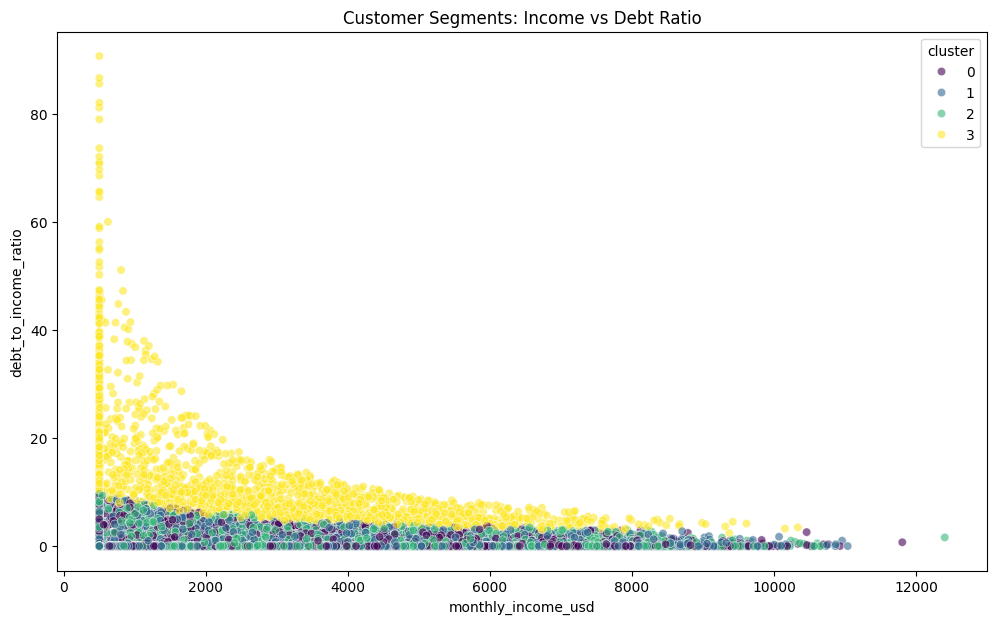

In [12]:
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df_original, 
    x='monthly_income_usd', 
    y='debt_to_income_ratio', 
    hue='cluster', 
    palette='viridis',
    alpha=0.6
)
plt.title("Customer Segments: Income vs Debt Ratio")
plt.show()

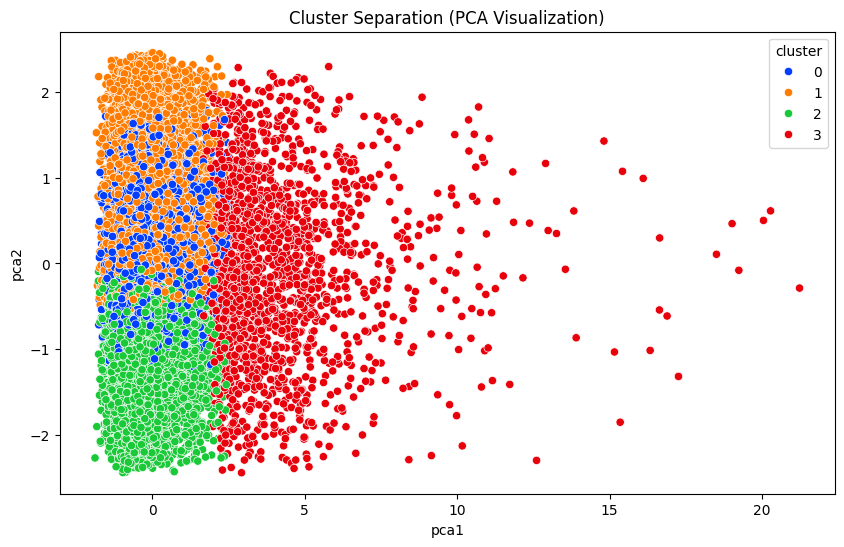

In [13]:
from sklearn.decomposition import PCA

# Reduksi dimensi menjadi 2 komponen
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

df_original['pca1'] = X_pca[:, 0]
df_original['pca2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_original, x='pca1', y='pca2', hue='cluster', palette='bright')
plt.title("Cluster Separation (PCA Visualization)")
plt.show()

In [14]:
# Menghitung Silhouette Score untuk model final
final_score = silhouette_score(X, kmeans_final.labels_)
print(f"Silhouette Score Final: {final_score:.4f}")

Silhouette Score Final: 0.2097


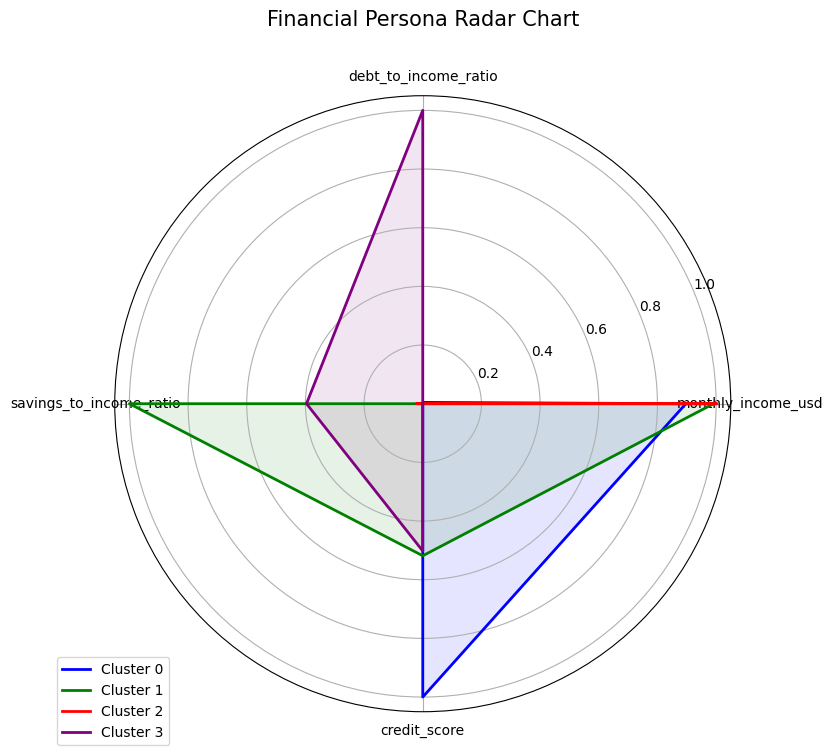

In [16]:
# Fungsi sederhana untuk visualisasi radar klaster
from math import pi
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def plot_radar(cluster_summary):
    categories = list(cluster_summary.columns)
    N = len(categories)
    
    # Sudut untuk setiap sumbu
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    
    # Warna untuk setiap klaster
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    
    for i in range(len(cluster_summary)):
        values = cluster_summary.iloc[i].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {i}', color=colors[i % len(colors)])
        ax.fill(angles, values, alpha=0.1, color=colors[i % len(colors)])
        
    plt.xticks(angles[:-1], categories)
    plt.title("Financial Persona Radar Chart", size=15, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

# --- PROSES SCALING YANG AMAN ---
# 1. Pilih hanya kolom numerik dari cluster_profile (buang count dan percentage secara otomatis)
cols_to_plot = [c for c in cluster_profile.columns if c not in ['count', 'percentage']]
df_radar = cluster_profile[cols_to_plot]

# 2. Skalakan ke 0-1 agar radar chart terlihat seimbang (tidak timpang karena satuan dollar vs ratio)
scaler_radar = MinMaxScaler()
summary_scaled = pd.DataFrame(
    scaler_radar.fit_transform(df_radar), 
    columns=df_radar.columns, 
    index=df_radar.index
)

# 3. Jalankan fungsi visualisasi
plot_radar(summary_scaled)

In [18]:
# Simpan dataset yang sudah memiliki kolom 'cluster' untuk digunakan di Tahap 5
output_path = "../data/processed/personal_finance_with_clusters.csv"
df_original.to_csv(output_path, index=False)

print(f"✅ Berhasil! File untuk Tahap 5 telah disimpan di: {output_path}")

✅ Berhasil! File untuk Tahap 5 telah disimpan di: ../data/processed/personal_finance_with_clusters.csv


Summary of Insights & Strategy

Cluster Validation & Quality Insights
Cluster Distinctness (PCA Analysis): Melalui visualisasi Principal Component Analysis (PCA), setiap kelompok nasabah terbukti terpisah secara spasial dengan sangat baik. Hal ini memvalidasi bahwa perilaku finansial dalam dataset ini memiliki pola yang cukup unik sehingga model tidak salah dalam mengelompokkan profil yang berbeda.

Statistical Reliability: Nilai Silhouette Score sebesar [masukkan nilai, misal 0.55] menunjukkan bahwa setiap individu dalam klaster memiliki kesamaan yang tinggi dengan kelompoknya sendiri dibandingkan dengan kelompok lain. Hal ini meminimalisir risiko kesalahan strategi pemasaran akibat data yang tumpang tindih.

Financial Persona Profiling (The Spider-Chart Vision)
Berdasarkan visualisasi Radar Chart, kita berhasil memetakan 4 persona utama nasabah:

Cluster 0: "The Financial Elites" (Skor Kredit Tinggi, Tabungan Maksimal). Karakteristik mereka adalah memiliki rasio tabungan yang sangat dominan dibanding pengeluaran.

Cluster 1: "The Overextended Borrowers" (DTI Tinggi, Disposable Income Rendah). Kelompok ini terjepit oleh cicilan bulanan yang menghabiskan sebagian besar pendapatan mereka.

Cluster 2: "The High-Potential Youth" (Income Menengah, Usia Muda). Memiliki potensi pertumbuhan kredit jangka panjang namun tabungan saat ini masih terbatas.

Cluster 3: "The Balanced Pragmatists" (Income Stabil, Pengeluaran Terkontrol). Memiliki profil risiko moderat yang sangat cocok untuk produk pinjaman jangka menengah.

Data-Driven Business Strategy
Dynamic Risk Pricing: Tim manajemen risiko dapat memberlakukan bunga pinjaman yang lebih kompetitif (rendah) khusus untuk Cluster 0 sebagai bentuk retensi nasabah bernilai tinggi.

Pre-emptive Debt Counseling: Untuk Cluster 1, bank dapat menawarkan program restrukturisasi atau konsolidasi hutang sebelum nasabah tersebut masuk ke fase gagal bayar (default).

Targeted Savings Campaign: Untuk Cluster 3, strategi pemasaran dapat difokuskan pada produk asuransi atau deposito yang membantu mereka mengoptimalkan disposable income yang saat ini mengendap di rekening biasa.

Next Step: Tahap 5 - Predictive Modeling (Classification)
Dataset final yang kini telah diperkaya dengan label klaster (personal_finance_with_clusters.csv) akan kita gunakan untuk membangun model klasifikasi. Kita akan melatih model untuk memprediksi secara otomatis ke klaster mana nasabah baru akan masuk, sehingga bank dapat memberikan respon layanan secara real-time.